In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!python3 -V

Python 3.10.0


# Setup

## Dependencies

In [3]:
import transformer_lens
from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

/opt/conda/envs/sprint/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
act_name = "mlp_out"

In [5]:
from sprint.vars import *
from sprint.sae_tutorial import *
from sprint.loading import load_all

model, all_tokens, encoder_l1 = load_all(model_name="gelu-2l", run_id="l1", use_half=False, fold_ln=True)

Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
Loading l1 from HuggingFace at gelu-2l_L1_16384_mlp_out_50
{'act_name': 'blocks.1.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 512,
 'device': 'cuda:0',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 1,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 50,
 'seq_len': 128,
 'site': 'mlp_out'}
Encoder device: cuda:0


In [6]:
print(all_tokens[0])

tensor([    1,    10, 27498, 29989,    65,  7147,    14, 29808,    11,   647,
          603,   417,  7481,    16,  3839,    16,  5635,   344,    10, 37123,
           65,  7147,  2192,   926,  6975, 36779, 34907,   255,  4608,  1551,
         2231, 17960, 38309,    18, 15553,  1102,   276, 41727,   347, 28881,
          347, 25859,   550,    19,  8983, 27498, 29989,  3333, 28881,  5811,
           10, 37123,    14,  1827,    16, 29902,    65,  2137,    65,  7147,
         1210,   647, 30343,    65, 22338,   426,   867,    10,   784,    65,
        22338,    10, 27498, 29989,    65,  7147,    14,   791, 10694,   567,
         6087, 14307,   647,  7876,    65,   927,    65, 32489,   426,  7954,
          647,   324,  2951,   276, 30343,    65, 22338,    28,   926,  7876,
           65,   927,    65, 32489,    16, 30777,    10,  1262,  3226,   784,
           65, 32737,    65,  3933,    65, 22968,    10,  4352,  1210,  2621,
         4311,    65, 32737,    65,   927,    65, 32489,   426],

In [7]:
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

In [23]:
batch_size = 32

## Using the Autoencoder

In [9]:
freqs = get_freqs(
    all_tokens=all_tokens, model=model, num_batches=50, local_encoder=encoder_l1, act_name="mlp_out", layer=1
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 48.39it/s]

Num dead tensor(0., device='cuda:0')


In [10]:
common_indices = torch.arange(encoder_l1.W_enc.shape[1]).to("cuda")[freqs > 1e-4]

In [11]:
common_indices[:50]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       device='cuda:0')

# Feature interpretation

In [12]:
# feature_id = 7 # @param {type:"number"}
batch_size = 64  # @param {type:"number"}

print(f"Feature freq: {freqs[7].item():.4f}")

Feature freq: 0.0484


Let's run the model on some text and then use the autoencoder to process the MLP activations

In [13]:
def get_feature_scores(model, encoder, tokens_arr, feature_idx, batch_size=64, act_name=act_name, layer=0):
    scores = []
    for i in tqdm.tqdm(range(0, tokens_arr.shape[0], batch_size)):
        # print(i, tokens_arr.shape[0], batch_size)
        with torch.no_grad():
            _, cache = model.run_with_cache(
                tokens_arr[i : i + batch_size], names_filter=[utils.get_act_name(act_name, layer)]
            )
            mlp_acts = cache[utils.get_act_name(act_name, layer)]
            mlp_acts_flattened = mlp_acts.reshape(-1, encoder.W_enc.shape[0])
            loss, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(mlp_acts_flattened)

        scores.append(
            utils.to_numpy(hidden_acts[:, feature_idx].reshape(batch_size, tokens_arr.shape[1])).astype(np.float16)
        )
    return np.concatenate(scores)

In [14]:
def get_dot_scores(model, tokens_arr, range_normal, batch_size=64, act_name=act_name, layer=0):
    scores = []
    for i in tqdm.tqdm(range(0, tokens_arr.shape[0], batch_size)):
        # print(i, tokens_arr.shape[0], batch_size)
        with torch.no_grad():
            _, cache = model.run_with_cache(
                tokens_arr[i : i + batch_size], names_filter=[utils.get_act_name(act_name, layer)]
            )
            mlp_acts = cache[utils.get_act_name(act_name, layer)]
            mlp_acts_flattened = mlp_acts.reshape(-1, mlp_acts.shape[-1])
            cur_scores = mlp_acts_flattened @ range_normal

        scores.append(utils.to_numpy(cur_scores).astype(np.float16))
    return np.concatenate(scores)

In [15]:
scores = get_feature_scores(model, encoder_l1, all_tokens[: 128 * 100], 8, batch_size=128, layer=1)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 32.11it/s]


In [16]:
scores.shape

(12800, 128)

In [17]:
# PC: this is basically the same as getting the stashed activations in analyze_linearized_feature

tokens = all_tokens[: 128 * 100]
token_df = make_token_df(tokens, model=model)
token_df["feature"] = scores.reshape(-1)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
1608723,·',·'/19,"',↩ ············'city':|·'|Be",12568,19,12568/19,7.277344
788886,·',·'/22,"',↩ ············'name':|·'|Arthur",6163,22,6163/22,6.652344
253044,·',·'/116,·{↩ ············'id':|·'|5,1976,116,1976/116,6.488281
995947,·',·'/107,"',↩ ········'name':|·'|Arthur",7780,107,7780/107,6.441406
120395,·',·'/75,"',·**{'family':|·'|serif",940,75,940/75,6.417969
576401,·',·'/17,2106':|·'|s,4503,17,4503/17,6.371094
1144463,·',·'/15,"·None,·'name':|·'|mock",8941,15,8941/15,6.339844
1614359,·',·'/23,·{↩ ········'title':|·'|Gall,12612,23,12612/23,6.281250
788879,·',·'/15,·{↩ ············'title':|·'|King,6163,15,6163/15,6.261719
187870,·',·'/94,"email,·'title':|·'|fo",1467,94,1467/94,6.210938


In [18]:
feature_idx = 8  # @param {type:"number"}

## Feature interpretation

In [19]:
def get_feature_scores_for_prompt(model, encoder, prompt, feature, act_name=act_name, layer=0, prepend_bos=True):
    with torch.no_grad():
        _, cache = model.run_with_cache(
            prompt, names_filter=[utils.get_act_name(act_name, layer)], prepend_bos=prepend_bos
        )
        acts = cache[utils.get_act_name(act_name, layer)]
        acts = acts.reshape(-1, encoder.W_enc.shape[0])
        loss, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(acts)
    return utils.to_numpy(hidden_acts[:, feature])

# Feature propagation

In [20]:
feature_example_idx = 12568
feature_token_idx = 19

### Linearize through MLP1

In [81]:
from sprint.linearization import analyze_linearized_feature, cossim

result_noln = analyze_linearized_feature(
    feature_idx=feature_idx,
    sample_idx=feature_example_idx,
    token_idx=feature_token_idx,
    model=model,
    encoder=encoder_l1,
    layer=1,
    data=all_tokens,
    mlp_out=True,
    use_ln=False,
)

result = analyze_linearized_feature(
    feature_idx=feature_idx,
    sample_idx=feature_example_idx,
    token_idx=feature_token_idx,
    model=model,
    encoder=encoder_l1,
    layer=1,
    data=all_tokens,
    mlp_out=True,
    use_ln=True,
)

cossim(result_noln["mid"], result["mid"])

0.97216796875

### Unembed feature

Before investigating attention, first, see if directly unembedding the feature yields us anything.

In [82]:
feature_unembed = model.W_E @ result_noln["mid"]

In [83]:
def get_top_tokens(tokenizer, vector, k=5, reverse=False):
    topk = torch.topk(vector, k=k, largest=(not reverse))
    return topk.values, tokenizer.batch_decode([[x] for x in topk.indices])

In [84]:
def plot_top_tokens(model, unembedded_feature, k=10):
    token_scores, token_strs = get_top_tokens(model.tokenizer, unembedded_feature, k=k)

    token_df = pd.DataFrame(
        dict(str_tokens=process_tokens(token_strs, model=model), feature_scores=token_scores.detach().cpu().numpy())
    )
    token_df = token_df.style.background_gradient("coolwarm")
    display(token_df)

In [85]:
plot_top_tokens(model, model.W_E @ result_noln["mid"], k=10)

,str_tokens,feature_scores
0,·inex,2.837891
1,·έ,2.826172
2,·immer,2.710938
3,·veh,2.666016
4,·iç,2.617188
5,ή,2.585938
6,·ec,2.560547
7,·contin,2.556641
8,·reign,2.552734
9,·ris,2.546875


In [88]:
plot_top_tokens(model, model.W_E @ result["mid"], k=10)

,str_tokens,feature_scores
0,·inex,2.119141
1,·ec,1.960938
2,·prec,1.880859
3,·gli,1.860352
4,·ign,1.845703
5,·enorm,1.843750
6,·έ,1.840820
7,·iç,1.834961
8,·immer,1.823242
9,·ris,1.820312


In [90]:
sorted_vals, sorted_indices = torch.sort(model.W_E @ result["mid"], descending=True)

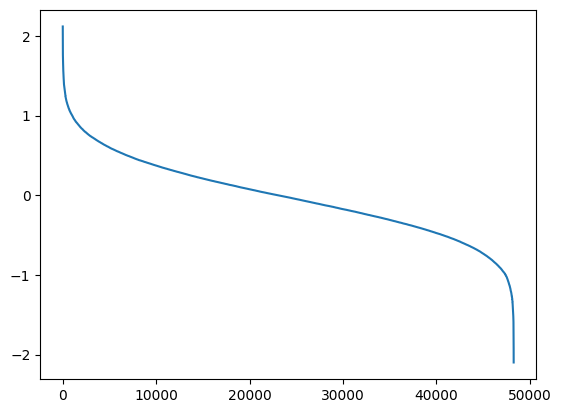

In [91]:
plt.plot(sorted_vals.detach().cpu().numpy())

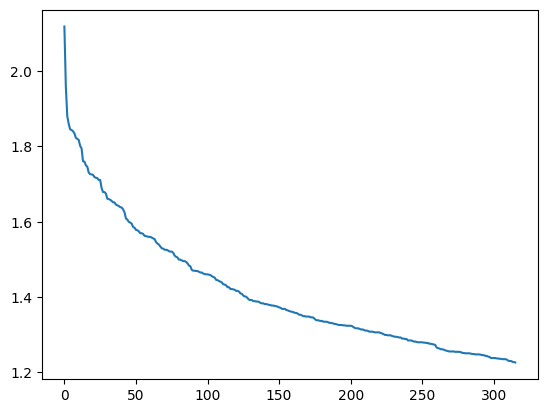

In [92]:
plt.plot(sorted_vals.detach().cpu().numpy()[: 158 * 2])

In [93]:
sorted_vals, sorted_indices = torch.sort(model.W_E @ result["mid"], descending=True)

In [94]:
torch.arange(len(sorted_vals))[sorted_indices.to("cpu") == model.to_single_token(" '")]

tensor([158])

Looks like the direct path to the unembeddings from MLP1 doesn't bear any interpretable fruit; certainly, these are not the tokens that we'd expect from the top activating examples. Can we use this to create an adversarial prompt?

In [ ]:
def to_token_list(prompt):
    return model.tokenizer.batch_decode(model.tokenizer.encode(prompt))

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "        {'name': 'John'}", feature_idx, layer=1)

array([0.   , 0.   , 0.   , 0.   , 0.   , 4.938, 0.   , 0.   ],
      dtype=float16)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "test': inex", feature_idx, layer=1, prepend_bos=False)

array([0.   , 0.753, 0.   ], dtype=float16)

Nope, no dice. Looks like the direct path doesn't do much. What about the path through MLP0?

### Understand weird feature

Per Neel's advice: patch direct path, interpolating between a token we understand (i.e. ` '`) and a token we don't (i.e. ` inex`).

In [ ]:
interp_scores = []

In [ ]:
ln2_mlp_until_out(
    model.W_E[model.to_single_token(" '")][None, None, :] + model.W_pos[40], model.blocks[1].ln2, model.blocks[1].mlp
) @ feature_l1_out

tensor([[-4.0625]], device='cuda:0', dtype=torch.float16,
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
ln2_mlp_until_out(
    model.W_E[model.to_single_token(" inex")][None, None, :] + model.W_pos[40], model.blocks[1].ln2, model.blocks[1].mlp
) @ feature_l1_out

tensor([[2.0918]], device='cuda:0', dtype=torch.float16,
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
ln2_mlp_until_out(
    model.W_E[model.to_single_token(" enorm")][None, None, :], model.blocks[1].ln2, model.blocks[1].mlp
) @ feature_l1_out

tensor([[1.0020]], device='cuda:0', dtype=torch.float16,
       grad_fn=<UnsafeViewBackward0>)

In [95]:
# @torch.no_grad()
# def activation_steering(model, prompt, steering_info, measure_info, encoder=None):
#     # steering_info: {'layer', 'act_name', 'token', 'vec'}
#     # if use_sae: measure_info is like {'layer', 'act_name', 'token', 'feature_idx'}
#     # otherwise, measure_info is like {'layer', 'act_name', 'token', 'vec'}
#     def steer_hook_fn(activation, hook):
#         new_activation = activation.clone()
#         new_activation[0, steering_info["token"]] = activation[0, steering_info["token"]] + steering_info["vec"]
#         return new_activation

#     measure_act_str = utils.get_act_name(measure_info["act_name"], measure_info["layer"])
#     steering_act_str = utils.get_act_name(steering_info["act_name"], measure_info["layer"])

#     _, cache_unsteered = model.run_with_cache(prompt, names_filter=[steering_act_str, measure_act_str])
#     with model.hooks(fwd_hooks=[(steering_act_str, steer_hook_fn)]):
#         _, cache_steered = model.run_with_cache(prompt, names_filter=[steering_act_str, measure_act_str])

#     if encoder is not None:
#         _, _, unsteered_hidden_acts, _, _ = encoder(cache_unsteered[measure_act_str])
#         _, _, steered_hidden_acts, _, _ = encoder(cache_steered[measure_act_str])
#         unsteered_score = unsteered_hidden_acts[0, measure_info["token"], measure_info["feature_idx"]].item()
#         steered_score = steered_hidden_acts[0, measure_info["token"], measure_info["feature_idx"]].item()
#     else:
#         unsteered_score = (cache_unsteered[measure_act_str][0, measure_info["token"]] @ measure_info["vec"]).item()
#         steered_score = (cache_steered[measure_act_str][0, measure_info["token"]] @ measure_info["vec"]).item()
#     return unsteered_score, steered_score

from sprint.ablations import activation_steering

In [101]:
from sprint.linearization import get_feature_mid

In [110]:
token_df_sorted = token_df.sort_values("feature", ascending=False).head(100)
linear_sum = 0
count = 0
for cur_example, cur_pos in zip(token_df_sorted["batch"].iloc, token_df_sorted["pos"].iloc):
    linear_sum += get_feature_mid(
        all_tokens, cur_example, cur_pos, feature_idx, use_ln=True, layer=1, model=model, encoder=encoder_l1
    )
    count += 1
linear_sum /= count

In [111]:
plot_top_tokens(model, model.W_E @ linear_sum)

,str_tokens,feature_scores
0,·corro,1.846680
1,·deton,1.831055
2,·dra,1.781250
3,·έ,1.778320
4,·VERY,1.756836
5,·unders,1.754883
6,·cripp,1.739258
7,·ign,1.723633
8,·iç,1.694336
9,·immer,1.649414


In [112]:
# def quick_direct_patch(token):
#     _, cache = model.run_with_cache("{'name': '")
#     clean_act = cache[utils.get_act_name("resid_mid", 1)]
#     dirty_act = clean_act.clone()
#     dirty_act[0, -1, :] = (
#         dirty_act[0, -1, :] - model.W_E[model.to_single_token(" '")] + model.W_E[model.to_single_token(token)]
#     )
#     _, _, hidden_clean, _, _ = encoder_l1(ln2_mlp_until_out(clean_act, model.blocks[1].ln2, model.blocks[1].mlp)[0, -1])
#     _, _, hidden_dirty, _, _ = encoder_l1(ln2_mlp_until_out(dirty_act, model.blocks[1].ln2, model.blocks[1].mlp)[0, -1])
#     return hidden_dirty[feature_idx] - hidden_clean[feature_idx]

from sprint.ablations import quick_direct_patch

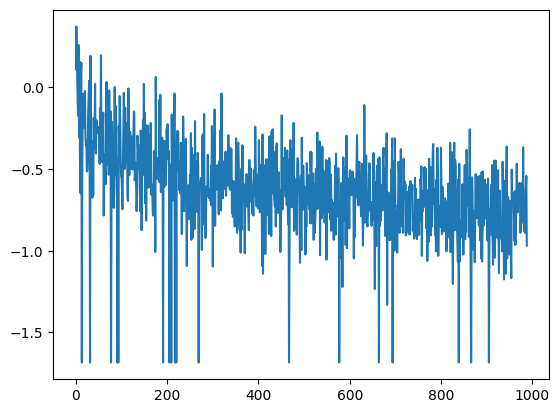

In [113]:
quick_patch_results = []

for token in get_top_tokens(model.tokenizer, model.W_E @ linear_sum, k=1000)[1]:
    try:
        # quick_patch_results.append(quick_direct_patch(token).item())
        quick_patch_results.append(
            quick_direct_patch(token, model=model, sae=encoder_l1, feature_idx=feature_idx, layer=1).item()
        )
    except:
        pass

plt.plot(quick_patch_results)

In [114]:
# @torch.no_grad()
# def quick_direct_patch_interp(token, t):
#     _, cache = model.run_with_cache("{'name': '")
#     clean_act = cache[utils.get_act_name("resid_mid", 1)]
#     dirty_act = clean_act.clone()
#     dirty_act[0, -1, :] = (
#         dirty_act[0, -1, :] - t * model.W_E[model.to_single_token(" '")] + t * model.W_E[model.to_single_token(token)]
#     )
#     _, _, hidden_clean, _, _ = encoder_l1(ln2_mlp_until_out(clean_act, model.blocks[1].ln2, model.blocks[1].mlp)[0, -1])
#     _, _, hidden_dirty, _, _ = encoder_l1(ln2_mlp_until_out(dirty_act, model.blocks[1].ln2, model.blocks[1].mlp)[0, -1])
#     return (hidden_dirty[feature_idx] - hidden_clean[feature_idx]).item()

from sprint.ablations import quick_direct_patch_interp

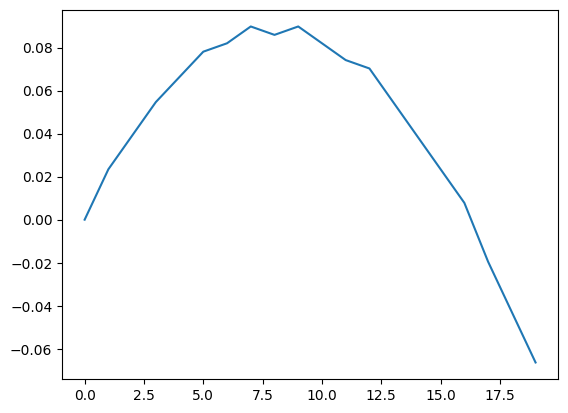

In [115]:
quick_interp_results = []
for t in np.arange(0, 1, 0.05):
    # quick_interp_results.append(quick_direct_patch_interp(" VERY", t))
    quick_interp_results.append(
        quick_direct_patch_interp(" VERY", t, model=model, sae=encoder_l1, feature_idx=feature_idx, layer=1)
    )
plt.plot(quick_interp_results)

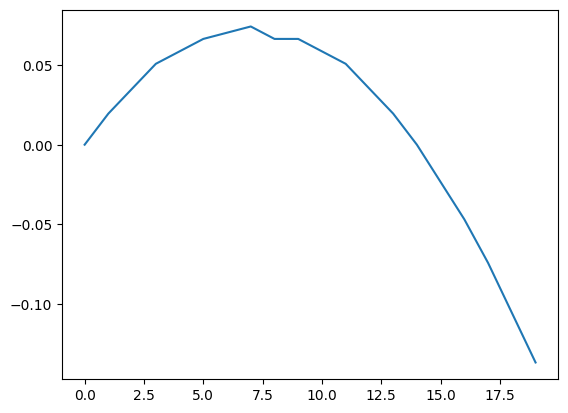

In [116]:
quick_interp_results = []
for t in np.arange(0, 1, 0.05):
    # quick_interp_results.append(quick_direct_patch_interp(" unders", t))
    quick_interp_results.append(
        quick_direct_patch_interp(" unders", t, model=model, sae=encoder_l1, feature_idx=feature_idx, layer=1)
    )
plt.plot(quick_interp_results)

In [ ]:
quick_direct_patch_interp(" VERY", 0, model=model, sae=encoder_l1, feature_idx=feature_idx, layer=1)

0.0

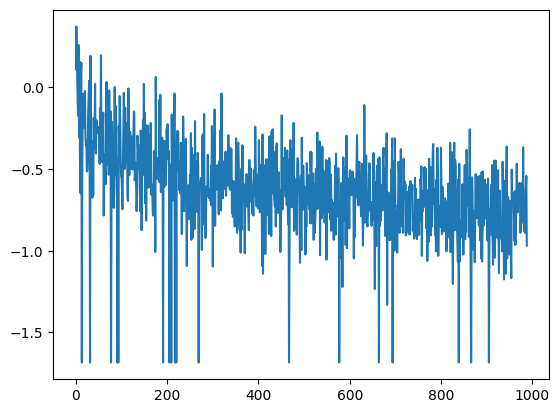

In [117]:
quick_patch_results = []

for token in get_top_tokens(model.tokenizer, model.W_E @ linear_sum, k=1000)[1]:
    try:
        # quick_patch_results.append(quick_direct_patch(token).item())
        quick_patch_results.append(
            quick_direct_patch(token, model=model, sae=encoder_l1, feature_idx=feature_idx, layer=1).item()
        )
    except:
        pass

plt.plot(quick_patch_results)

## DLA

In [119]:
# @torch.no_grad()
# def dla(model, input, layer, range_normal, dst_token=-1, mid=False):
#     _, cache = model.run_with_cache(input)
#     dlas = []
#     print(cache[utils.get_act_name("attn_out", 0)].shape)
#     dlas.append(((cache[utils.get_act_name("resid_pre", 0)][:, dst_token] @ range_normal).item(), ("resid_pre", 0)))
#     for cur_layer in range(layer):
#         dlas.append(
#             (
#                 (cache[utils.get_act_name("attn_out", cur_layer)][:, dst_token] @ range_normal).item(),
#                 ("attn_out", cur_layer),
#             )
#         )
#         dlas.append(
#             (
#                 (cache[utils.get_act_name("mlp_out", cur_layer)][:, dst_token] @ range_normal).item(),
#                 ("mlp_out", cur_layer),
#             )
#         )

#     if mid:
#         dlas.append(
#             ((cache[utils.get_act_name("attn_out", layer)][:, dst_token] @ range_normal).item(), ("attn_out", layer))
#         )
#     return dlas

from sprint.ablations import dla

In [121]:
dla(model, all_tokens[feature_example_idx], 1, result["mid"], dst_token=feature_token_idx, mid=True)

torch.Size([1, 128, 512])


[(1.0703125, ('resid_pre', 0)),
 (1.337890625, ('attn_out', 0)),
 (2.65625, ('mlp_out', 0)),
 (-5.05859375, ('attn_out', 1))]

In [122]:
# try on a different example: 1976/116
dla(model, all_tokens[1976], 1, result["mid"], dst_token=116, mid=True)

torch.Size([1, 128, 512])


[(1.1123046875, ('resid_pre', 0)),
 (1.5625, ('attn_out', 0)),
 (2.609375, ('mlp_out', 0)),
 (-3.345703125, ('attn_out', 1))]

In [123]:
print(model.tokenizer.decode(all_tokens[feature_example_idx, : feature_token_idx + 1]))

<|BOS|>IN: {
            'country': 'de,cn,dk',
            'city': '


## Express layer1 feature in terms of layer0 features

In [124]:
# encoder_l0 = AutoEncoder.load_from_hf("gelu-2l_L0_16384_mlp_out_51")
encoder_l0 = AutoEncoder.load_from_hf("l0").to("cuda").half()

Loading l0 from HuggingFace at gelu-2l_L0_16384_mlp_out_51
{'act_name': 'blocks.0.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 512,
 'device': 'cuda:1',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 0,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 51,
 'seq_len': 128,
 'site': 'mlp_out'}


### Propagate feature into SAE

In [ ]:
encoder_l0.W_dec.shape

torch.Size([16384, 512])

In [ ]:
feature_mid1.shape

torch.Size([512])

In [ ]:
mlp0_feature_coeffs = encoder_l0.W_dec @ feature_mid1

In [ ]:
torch.linalg.norm(mlp0_feature_coeffs, ord=1)

tensor(2019., device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
top_mlp0_coeffs, top_mlp0_coeff_indices = torch.sort(mlp0_feature_coeffs)
top_mlp0_coeffs, top_mlp0_coeff_indices

(tensor([-0.5063, -0.4868, -0.4856,  ...,  0.5063,  0.5347,  0.6450],
        device='cuda:0', dtype=torch.float16, grad_fn=<SortBackward0>),
 tensor([ 3016, 12675,  8064,  ..., 11265,  4044,    81], device='cuda:0'))

In [ ]:
top_mlp0_coeffs[-4], top_mlp0_coeff_indices[-4]

(tensor(0.5010, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>),
 tensor(10630, device='cuda:0'))

### Look at high-scoring features

In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[: 128 * 100], 81, batch_size=128, layer=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 32.09it/s]


In [ ]:
tokens = all_tokens[: 128 * 100]
token_df = make_token_df(tokens, model=model)
token_df["feature"] = scores.reshape(-1)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
567082,·',·'/42,"6',·'null':|·'|True",4430,42,4430/42,6.402344
1073703,·',·'/39,"5',·'null':|·'|True",8388,39,8388/39,6.359375
242492,·',·'/60,"0',·'null':|·'|True",1894,60,1894/60,6.355469
1073743,·',·'/79,"5',·'null':|·'|True",8388,79,8388/79,6.335938
25131,·',·'/43,"5',·'null':|·'|True",196,43,196/43,6.320312
491058,·',·'/50,"0',·'null':|·'|True",3836,50,3836/50,6.312500
227646,·',·'/62,"8',·'null':|·'|True",1778,62,1778/62,6.269531
242531,·',·'/99,"0',·'null':|·'|True",1894,99,1894/99,6.265625
232473,·',·'/25,"0',·'null':|·'|True",1816,25,1816/25,6.207031
1624606,·',·'/30,"',·[],·{'null':|·'|True",12692,30,12692/30,6.191406


In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[: 128 * 100], 4044, batch_size=128, layer=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 31.86it/s]


In [ ]:
tokens = all_tokens[: 128 * 100]
token_df = make_token_df(tokens, model=model)
token_df["feature"] = scores.reshape(-1)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
1288077,>,>/13,ples.py·|···,10063,13,10063/13,8.031250
1116174,>,>/14,"SZ"">↩ ········|GN",8720,14,8720/14,7.753906
323988,>,>/20,>·:·|·<,2531,20,2531/20,7.691406
610021,>,>/101,"↩ ··············""······|0",4765,101,4765/101,7.667969
1007083,>,>/107,"exact"">↩ ············|q",7867,107,7867/107,7.660156
250809,>,>/57,*(?P|[^,1959,57,1959/57,7.636719
323983,>,>/15,↩ ········#···|·:,2531,15,2531/15,7.605469
630978,>,>/66,".0""?>|http",4929,66,4929/66,7.558594
1514141,>,>/29,·[score=||,11829,29,11829/29,7.542969
406029,>,>/13,"/"">↩ ··|7",3172,13,3172/13,7.527344


In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[: 128 * 100], 11265, batch_size=128, layer=0)
tokens = all_tokens[: 128 * 100]
token_df = make_token_df(tokens, model=model)
token_df["feature"] = scores.reshape(-1)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 32.05it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
307843,"=""","=""/3","<|BOS|>↩ ····url|=""|https",2405,3,2405/3,6.980469
181265,"=""","=""/17","xsd:enumeration·value|=""|LOAD",1416,17,1416/17,6.957031
713729,"=""","=""/1","<|BOS|>|=""|Username",5576,1,5576/1,6.761719
798721,"=""","=""/1","<|BOS|>|=""|project",6240,1,6240/1,6.761719
1068929,"=""","=""/1","<|BOS|>|=""|"")",8351,1,8351/1,6.761719
18945,"=""","=""/1","<|BOS|>|=""|on",148,1,148/1,6.761719
1012609,"=""","=""/1","<|BOS|>|=""|duration",7911,1,7911/1,6.761719
1385217,"=""","=""/1","<|BOS|>|=""|icon",10822,1,10822/1,6.761719
1567745,"=""","=""/1","<|BOS|>|=""|R",12248,1,12248/1,6.761719
56321,"=""","=""/1","<|BOS|>|=""|password",440,1,440/1,6.761719


In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[: 128 * 100], 10630, batch_size=128, layer=0)
tokens = all_tokens[: 128 * 100]
token_df = make_token_df(tokens, model=model)
token_df["feature"] = scores.reshape(-1)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 31.88it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
19976,�,�/8,·operation.↩ ��|�|·Dam,156,8,156/8,4.187500
20016,�,�/48,·crack).↩ ��|�|·O,156,48,156/48,4.156250
1274020,�,�/36,سباران�|�|·or,9953,36,9953/36,3.958984
1369522,�,�/50,·first·episode.↩ �|�|·That,10699,50,10699/50,3.794922
20080,�,�/112,·cylinder.↩ ��|�|·Inc,156,112,156/112,3.759766
1369510,�,�/38,·Fantasy·XV.↩ �|�|·And,10699,38,10699/38,3.634766
1373868,�,�/44,█��··�|�|█,10733,44,10733/44,3.576172
1373862,�,�/38,█��··�|�|█,10733,38,10733/38,3.517578
1373840,�,�/16,·����·�|�|█,10733,16,10733/16,3.490234
175723,�,�/107,$MM/······�|�|�,1372,107,1372/107,3.458984


Now look at features with most negative coefficients

In [ ]:
scores = get_feature_scores(model, encoder_l0, all_tokens[: 128 * 100], 3016, batch_size=128, layer=0)
tokens = all_tokens[: 128 * 100]
token_df = make_token_df(tokens, model=model)
token_df["feature"] = scores.reshape(-1)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 32.10it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
870058,·Phil,·Phil/42,".↩ Unfortunately·however,|·Phil|ips",6797,42,6797/42,13.570312
1560913,·Phil,·Phil/81,·using·technology·at·all.|·Phil|ips,12194,81,12194/81,13.304688
721246,·Phil,·Phil/94,·he·had·a·daughter·named|·Phil|a,5634,94,5634/94,13.156250
744154,·Phil,·Phil/90,·as·well·but·will·ask|·Phil|·about,5813,90,5813/90,12.570312
870138,·Phil,·Phil/122,",·but·in·my·opinion|·Phil|ips",6797,122,6797/122,10.804688
1497547,Phil,Phil/75,·their·meal·preparation.↩ |Phil|·Heath,11699,75,11699/75,9.828125
1497565,·Phil,·Phil/93,ia·2018|·Phil|·Heath,11699,93,11699/93,9.578125
721274,·Phil,·Phil/122,·proof·we·can·find·that|·Phil|a,5634,122,5634/122,9.546875
2110,·Nicolas,·Nicolas/62,.·Uveous·following|·Nicolas|·engages,16,62,16/62,1.686523
1559412,·Chrys,·Chrys/116,"·earlier·in·the·thread,|·Chrys|alis",12182,116,12182/116,1.647461


The top feature seems extremely interpretable, and very much in keeping with what the second-layer feature that we're investigating does. But what's with all these other features? One possibility is that there's a form of "superposition" going on, where all of these features cancel each other out in just the right way so as to leave only the top feature remaining.

Thus, instead of trying to directly compute $c$ (the vector of feature coefficients), we can try and find a "sparsified" version of $c$: a vector $c'$ such that $c'$ has low L1 norm but $c-c'$ has low L2 norm.

## MLP1 <- MLP0

In [159]:
from sprint.linearization import get_feature_mid

In [163]:
feature_mlp1_mlp0_noln = get_feature_mid(
    all_tokens,
    feature_example_idx,
    feature_token_idx,
    feature_idx,
    use_ln=False,
    layer=0,
    model=model,
    encoder=encoder_l1,
    feature=result["mid"],
)

In [164]:
feature_mlp1_mlp0 = get_feature_mid(
    all_tokens,
    feature_example_idx,
    feature_token_idx,
    feature_idx,
    use_ln=True,
    layer=0,
    model=model,
    encoder=encoder_l1,
    feature=result["mid"],
)

In [165]:
cossim(feature_mlp1_mlp0_noln, feature_mlp1_mlp0)

0.91162109375

### Token unembeddings

In [166]:
plot_top_tokens(model, model.W_E @ feature_mlp1_mlp0_noln)

,str_tokens,feature_scores
0,=”,2.394531
1,"=""'",2.357422
2,':',2.273438
3,"·""'",2.261719
4,"=""",2.199219
5,\),2.177734
6,"—""",2.167969
7,",—",2.164062
8,"-""",2.158203
9,"""...",2.156250


In [167]:
plot_top_tokens(model, model.W_E @ feature_mlp1_mlp0)

,str_tokens,feature_scores
0,"""...",5.597656
1,"=""'",5.550781
2,",""",5.363281
3,\),5.214844
4,=”,5.171875
5,"-""",5.164062
6,·---------------------,5.160156
7,"·""\",5.085938
8,·Г,5.062500
9,^[,5.019531


Nice! Now we're getting somewhere!

In [168]:
sorted_vals, sorted_indices = torch.sort(model.W_E @ feature_mlp1_mlp0, descending=True)

In [169]:
torch.arange(len(sorted_vals))[sorted_indices.to("cpu") == model.to_single_token(" '")]

tensor([102])

### Top examples

In [170]:
scores = get_dot_scores(
    model, all_tokens[: 128 * 100], feature_mlp1_mlp0, batch_size=128, layer=0, act_name="resid_mid"
)
tokens = all_tokens[: 128 * 100]
token_df = make_token_df(tokens, model=model)
token_df["feature"] = scores.reshape(-1)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 53.07it/s]


,str_tokens,unique_token,context,batch,pos,label,feature
394469,·',·'/101,_EXTENSIBLE·=|·'|Ext,3081,101,3081/101,3.531250
796024,"""","""/120","↩ #4·:·u|""|av",6218,120,6218/120,3.296875
1178960,·',·'/80,"',·[],·{'unique':|·'|True",9210,80,9210/80,3.201172
1273191,·',·'/103,"',·[],·{'unique':|·'|True",9946,103,9946/103,3.146484
1446843,·',·'/59,"',·[],·{'unique':|·'|True",11303,59,11303/59,3.109375
1467854,"""","""/78","A·rich·lunatic,\|""|·they",11467,78,11467/78,3.095703
1060149,','/53,·u'ą':·u|'|a,8282,53,8282/53,3.044922
796005,"""","""/101","↩ #2·:·u|""|f",6218,101,6218/101,3.037109
796015,"""","""/111","↩ #3·:·u|""|m",6218,111,6218/111,3.017578
658538,','/106,"downarrow'·················:·r|'|',",5144,106,5144/106,3.003906


There are some similarities between this path's feature and the original one. In particular, this path's feature seems to fire on a larger number of "open string delimiter in a key-value context" tokens; compare to the original one, which fired on primarily the ` '` token.

## mlp1 <- attn0

### Attention attribution

In [ ]:
# def get_attn_head_contribs(model, cache, layer, range_normal):
#     split_vals = cache[utils.get_act_name("v", layer)]
#     attn_pattern = cache[utils.get_act_name("pattern", layer)]
#     #'batch head dst src, batch src head d_head -> batch head dst src d_head'
#     weighted_vals = torch.einsum("b h d s, b s h f -> b h d s f", attn_pattern, split_vals)

#     # 'batch head dst src d_head, head d_head d_model -> batch head dst src d_model'
#     weighted_outs = torch.einsum("b h d s f, h f m -> b h d s m", weighted_vals, model.W_O[layer])

#     # 'batch head dst src d_model, d_model -> batch head dst src'
#     contribs = torch.einsum("b h d s m, m -> b h d s", weighted_outs, range_normal)

#     return contribs


# def get_attn_head_contribs_ov(model, cache, layer, range_normal):
#     split_vals = cache[utils.get_act_name("v", layer)]

#     # 'batch src head d_head, head d_head d_model -> batch head src d_model'
#     weighted_outs = torch.einsum("b s h f, h f m -> b h s m", split_vals, model.W_O[layer])

#     # 'batch head src d_model, d_model -> batch head src'
#     contribs = torch.einsum("b h s m, m -> b h s", weighted_outs, range_normal)

#     return contribs

from sprint.attention import get_attn_head_contribs, get_attn_head_contribs_ov
from sprint.visualization import plot_attn_contribs_for_example, plot_attn_pattern_for_example

In [ ]:
import plotly.io as pio

pio.renderers.default = "iframe"

In [ ]:
# def plot_attn_contribs_for_example(
#     model, example_idx, token_idx, feature_mid, start_token_idx=0, ov_only=False, layer=0
# ):
#     with torch.no_grad():
#         tokens = all_tokens[example_idx]
#         _, cache = model.run_with_cache(
#             tokens,
#             names_filter=[
#                 utils.get_act_name("pattern", layer),
#                 utils.get_act_name("v", layer),
#             ],
#         )
#         if not ov_only:
#             attn_contribs = get_attn_head_contribs(model, cache, layer, feature_mid)
#             attn_contribs_window = attn_contribs[0, :, token_idx, start_token_idx : token_idx + 1]
#         else:
#             attn_contribs = get_attn_head_contribs_ov(model, cache, layer, feature_mid)
#             attn_contribs_window = attn_contribs[0, :, start_token_idx : token_idx + 1]
#         print(attn_contribs_window.sum().item())
#         fig = px.imshow(
#             utils.to_numpy(attn_contribs_window),
#             x=list(
#                 map(
#                     lambda x, i: f"|{process_token(x)}| pos {str(i)}",
#                     model.tokenizer.batch_decode(tokens[start_token_idx : token_idx + 1]),
#                     range(start_token_idx, token_idx + 1),
#                 )
#             ),
#             color_continuous_midpoint=0,
#         )
#         fig.update_xaxes(tickangle=90)
#     fig.show()

In [ ]:
# def plot_attn_pattern_for_example(model, example_idx, token_idx, start_token_idx=0, layer=0):
#     with torch.no_grad():
#         tokens = all_tokens[example_idx]
#         _, cache = model.run_with_cache(
#             tokens,
#             stop_at_layer=1,
#             names_filter=[
#                 utils.get_act_name("pattern", layer),
#             ],
#         )
#         fig = px.imshow(
#             utils.to_numpy(
#                 cache[utils.get_act_name("pattern", layer)][0, :, token_idx, start_token_idx : token_idx + 1]
#             ),
#             x=list(
#                 map(
#                     lambda x, i: f"|{process_token(x)}| pos {str(i)}",
#                     model.tokenizer.batch_decode(tokens[start_token_idx : token_idx + 1]),
#                     range(start_token_idx, token_idx + 1),
#                 )
#             ),
#             color_continuous_midpoint=0,
#         )
#         fig.update_xaxes(tickangle=90)
#     fig.show()

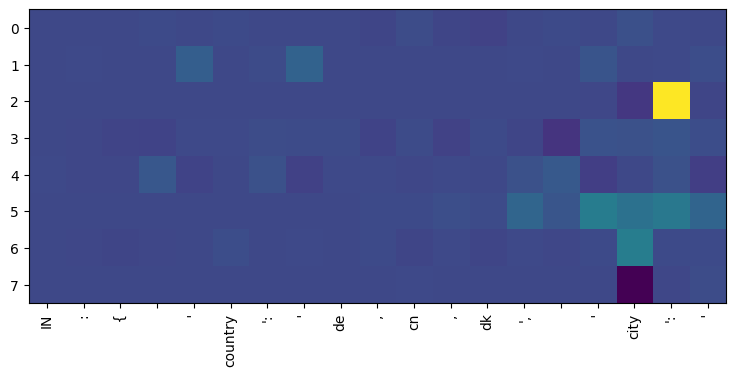

In [ ]:
plot_attn_contribs_for_example(
    model=model,
    data=all_tokens,
    example_idx=feature_example_idx,
    token_idx=feature_token_idx,
    feature_mid=feature_mid1,
    start_token_idx=1,
)

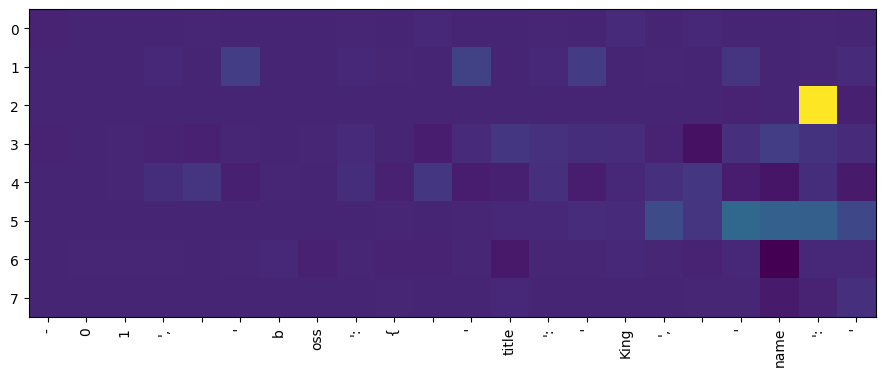

In [ ]:
plot_attn_contribs_for_example(
    model=model, data=all_tokens, example_idx=6163, token_idx=22, feature_mid=feature_mid1, start_token_idx=1
)

The pattern here seems obvious: head 2 fires on the token `':` in the previous position. 

In [ ]:
from sprint.attention import do_single_token_qk

In [ ]:
do_single_token_qk(" '", "':", 2, dst_pos=22, src_pos=21, model=model)

46.5625

In [ ]:
do_single_token_qk(" '", "':", 2, dst_pos=22, src_pos=19, model=model)

19.796875

### Propagation through attention

In [ ]:
from sprint.linearization import ln_ov

In [ ]:
# PC: this is kind of already subsumed into linearization.analyze_linearized_feature - but we'll keep it for now


def get_ov_unembed(model, head, feature_mid, ln_token=None, pos_idx=0, layer=0, unembed=True):
    if ln_token is None:
        x = model.OV[layer, head] @ feature_mid
    else:
        x = get_tangent_plane_at_point(
            model.W_E[model.to_single_token(ln_token)] + model.W_pos[pos_idx],
            lambda x: ln_ov(x, model, layer, head),
            feature_mid,
        )
    if unembed:
        x = model.W_E @ x
    return x

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 2, feature_mid1, pos_idx=20), k=20)

,str_tokens,feature_scores
0,·Î,0.313721
1,)=\,0.281738
2,))**(,0.277588
3,""":",0.274414
4,':,0.272949
5,·············,0.268066
6,·ن,0.268066
7,·**(,0.264648
8,·val,0.264404
9,=,0.262939


Hmm, not as obvious as initially thought. **TODO**: investigate what the deal is with those top three tokens 

#### What's going on?

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "{'name': 'John'}", feature_idx, layer=1)

array([0.   , 0.   , 0.   , 0.   , 5.223, 0.   , 0.   ], dtype=float16)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "': '", feature_idx, layer=1)

array([0.   , 0.   , 4.543], dtype=float16)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "))**( '", feature_idx, layer=1)

array([0.  , 0.  , 1.03], dtype=float16)

In [ ]:
print(")=\\")

)=\


In [ ]:
get_feature_scores_for_prompt(
    model, encoder_l1, "'my_val': 'my_fake_dict_assignment: 'key': 'val'", feature_idx, layer=1
)

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 4.07  , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.1816,
       1.874 , 0.    , 0.    , 2.457 , 0.    , 0.    ], dtype=float16)

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, ")=\\'", feature_idx, layer=1)

array([0.    , 0.    , 0.4043], dtype=float16)

In [ ]:
(model.W_E @ feature_mlp1_mlp0_noln)[model.to_single_token("))**(")]

tensor(1.8779, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

In [ ]:
(model.W_E @ feature_mlp1_mlp0_noln)[model.to_single_token("':")]

tensor(1.2129, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

In [ ]:
(model.W_E @ feature_mlp1_mlp0_noln)[model.to_single_token(")=\\")]

tensor(1.4814, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

In [ ]:
model.tokenizer.batch_decode(model.tokenizer.encode("<|BOS|>)=\ '"))

['<|BOS|>', ')=\\', " '"]

### QK circuits

#### Positional

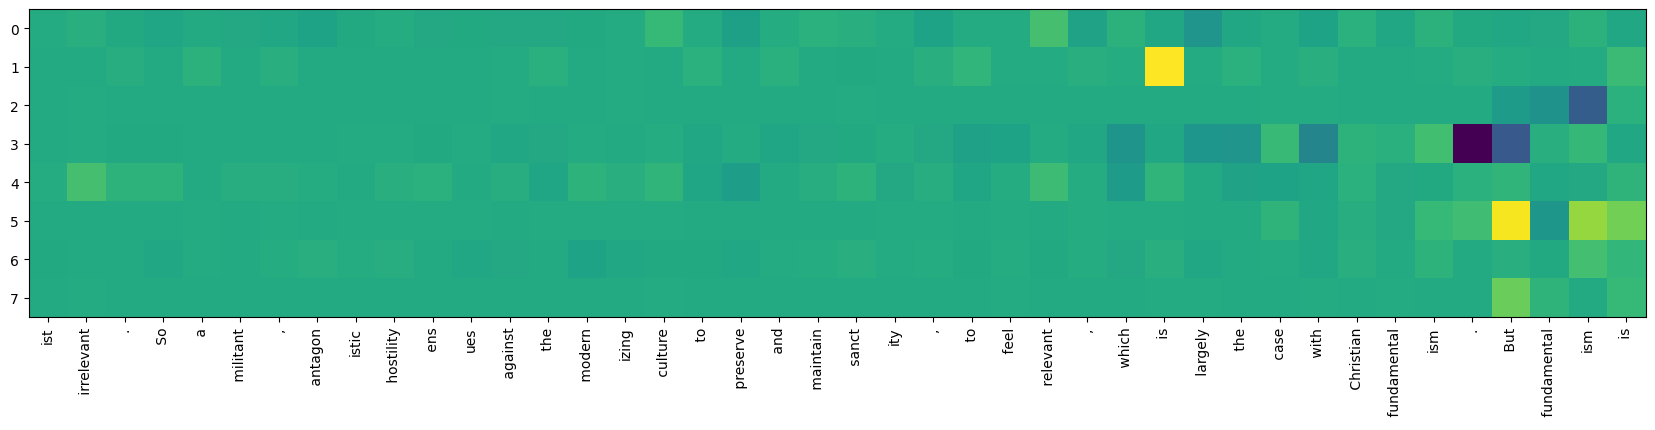

In [ ]:
plot_attn_contribs_for_example(model, all_tokens, 3976, 42, feature_mid1, start_token_idx=1)

In [ ]:
plot_attn_pattern_for_example(model, all_tokens, 3976, 42, start_token_idx=1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.29 GiB. GPU 0 has a total capacty of 22.16 GiB of which 10.35 GiB is free. Process 3537465 has 9.68 GiB memory in use. Process 3549305 has 1.18 GiB memory in use. Process 3549942 has 954.00 MiB memory in use. Of the allocated memory 403.50 MiB is allocated by PyTorch, and 78.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test_qk = (
    (model.W_E[model.to_single_token(" is")] + model.W_pos[10] + model.blocks[0].attn.b_Q.reshape(-1))
    @ model.QK[0, 0]
    @ model.W_pos.T
)

In [ ]:
model.blocks[0].attn.W_K.shape

torch.Size([8, 512, 64])

In [ ]:
# TODO: account for ln1
def get_pos_scores(
    dst_token_str, src_token_str, head, dst_pos=40, use_b_Q=False, use_b_K=False, use_ln=False, pos_lag=0
):
    max_pos_list = []
    query = model.W_E[model.to_single_token(dst_token_str)] + model.W_pos[dst_pos]
    if use_ln:
        query = model.blocks[0].ln1(query)
    query = query @ model.blocks[0].attn.W_Q[head]
    if use_b_Q:
        query = query + model.blocks[0].attn.b_Q[head]

    key = model.W_pos[: dst_pos + 1 - pos_lag] + model.W_E[model.to_single_token(src_token_str)]
    if use_ln:
        key = model.blocks[0].ln1(key)
    key = key @ model.blocks[0].attn.W_K[head]
    if use_b_K:
        key = key + model.blocks[0].attn.b_K[head]

    test_qk = query @ key.T
    return test_qk.detach().cpu().numpy()

In [ ]:
get_pos_scores(" is", "ism", 4, dst_pos=42, use_b_Q=True, use_b_K=True, use_ln=True).argmax()

0

In [ ]:
# TODO: account for ln1
def get_max_pos_scores(
    dst_token_str, src_token_str, head, pos_lag=0, end_pos=50, use_b_Q=False, use_b_K=False, use_ln=False
):
    max_pos_list = []
    xs = range(pos_lag, end_pos)
    for i in xs:
        test_qk = get_pos_scores(
            dst_token_str,
            src_token_str,
            head,
            dst_pos=i,
            pos_lag=pos_lag,
            use_b_Q=use_b_Q,
            use_b_K=use_b_K,
            use_ln=use_ln,
        )
        max_pos_list.append(test_qk.argmax())
    return xs, max_pos_list

In [ ]:
px.line(get_pos_scores(" is", "ism", 4, dst_pos=42, use_b_Q=True, use_b_K=True, use_ln=True))

TypeError: unsupported datatype in numpy array

TypeError: unsupported datatype in numpy array

TypeError: unsupported datatype in numpy array

Figure({
    'data': [{'hovertemplate': 'variable=0<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '0',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                          36, 37, 38, 39, 40, 41, 42]),
              'xaxis': 'x',
              'y': array([  1.677, -28.62 , -29.16 , -28.9  , -28.55 , -28.2  , -27.88 , -27.78 ,
                          -27.47 , -27.2  , -26.97 , -26.73 , -26.55 , -26.34 , -26.34 , -26.22 ,
                          -25.94 , -25.94 , -25.88 , -25.84 , -25.6  , -25.56 , -25.36 , -25.31 ,
                          -25

In [ ]:
xs0, ys0 = get_max_pos_scores(" is", "ism", 4, pos_lag=0, use_b_Q=True, use_b_K=True, use_ln=True)
xs1, ys1 = get_max_pos_scores(" is", "ism", 4, pos_lag=1, use_b_Q=True, use_b_K=True, use_ln=True)
xs2, ys2 = get_max_pos_scores(" is", "ism", 4, pos_lag=2, use_b_Q=True, use_b_K=True, use_ln=True)
xs5, ys5 = get_max_pos_scores(" is", "ism", 4, pos_lag=5, use_b_Q=True, use_b_K=True, use_ln=True)

In [ ]:
fig = px.line(x=xs0, y=ys0, markers=True)
fig.add_scatter(x=list(xs1), y=ys1, mode="lines")
fig.add_scatter(x=list(xs2), y=ys2, mode="lines")
fig.add_scatter(x=list(xs5), y=ys5, mode="lines")

In [ ]:
test_qk_sorted = torch.sort(test_qk)

In [ ]:
test_qk_sorted.values[:50]

tensor([-0.1054, -0.1049, -0.1023, -0.1014, -0.0995, -0.0994, -0.0990, -0.0987,
        -0.0981, -0.0968, -0.0966, -0.0961, -0.0959, -0.0956, -0.0948, -0.0947,
        -0.0937, -0.0923, -0.0919, -0.0917, -0.0915, -0.0901, -0.0898, -0.0889,
        -0.0878, -0.0877, -0.0865, -0.0863, -0.0854, -0.0835, -0.0831, -0.0830,
        -0.0827, -0.0819, -0.0816, -0.0813, -0.0809, -0.0804, -0.0803, -0.0794,
        -0.0794, -0.0794, -0.0794, -0.0790, -0.0788, -0.0786, -0.0782, -0.0781,
        -0.0777, -0.0776], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
torch.arange(model.W_E.shape[0])[test_qk_sorted.indices.cpu() == model.to_single_token(" is")]

tensor([6166])

In [ ]:
test_qk = model.W_E @ model.QK[0, 3] @ (model.W_E[model.to_single_token(" is")] + model.W_pos[42])

In [ ]:
test_qk_sorted = torch.sort(test_qk)

In [ ]:
test_qk_sorted.values[:50]

tensor([-0.7098, -0.7070, -0.6414, -0.6291, -0.6259, -0.5964, -0.5914, -0.5628,
        -0.5597, -0.5587, -0.5573, -0.5508, -0.5463, -0.5365, -0.5326, -0.5287,
        -0.5267, -0.5243, -0.5242, -0.5232, -0.5202, -0.5165, -0.5151, -0.5144,
        -0.5132, -0.5123, -0.5109, -0.5108, -0.5104, -0.5095, -0.5083, -0.5047,
        -0.5045, -0.5028, -0.5008, -0.4921, -0.4891, -0.4888, -0.4882, -0.4876,
        -0.4872, -0.4870, -0.4870, -0.4868, -0.4852, -0.4802, -0.4800, -0.4791,
        -0.4780, -0.4778], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
torch.arange(model.W_E.shape[0])[test_qk_sorted.indices.cpu() == model.to_single_token(" is")]

tensor([260])

In [ ]:
test_qk[model.to_single_token(" is")]

tensor(-0.3197, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
(model.W_E[model.to_single_token(" is")] @ model.QK[0, 4] @ model.W_E.T)[model.to_single_token(" fundamental")]

tensor(0.0205, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
model.blocks[0].attn.b_Q.shape

torch.Size([8, 64])

In [ ]:
plot_top_tokens(
    model,
    (model.W_E[model.to_single_token(" is")] + model.blocks[0].attn.b_Q.reshape(-1)) @ model.QK[0, 4] @ model.W_E.T,
    k=10,
)

,str_tokens,feature_scores
0,·[{,2.915863
1,·ranging,2.870203
2,·difference,2.828176
3,·as,2.821041
4,where,2.661981
5,·overview,2.600946
6,·ranged,2.585863
7,·huh,2.568143
8,Missing,2.551764
9,·terminating,2.526011


## MLP1 <- attn1

### Attention attribution

In [ ]:
plot_attn_contribs_for_example(model, feature_example_idx, feature_token_idx, feature_mid1, start_token_idx=0, layer=1)

-0.3347005844116211


In [ ]:
plot_attn_contribs_for_example(model, 6163, 22, feature_mid1, start_token_idx=1, layer=1)

3.396270990371704


### Propagation through attention

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 2, feature_mid1, pos_idx=20, layer=1), k=20)

,str_tokens,feature_scores
0,·OH,0.928490
1,·todd,0.901769
2,明,0.851172
3,。,0.810539
4,·Present,0.802941
5,·Posted,0.771234
6,·celebrating,0.762030
7,·innate,0.747316
8,·undes,0.746000
9,·present,0.738335


In [ ]:
get_ov_unembed(model, 7, feature_mid1, pos_idx=20, layer=1)[model.to_single_token(" '")]

tensor(0.1426, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
get_ov_unembed(model, 7, feature_mid1, pos_idx=20, layer=1)[model.to_single_token("))**(")]

tensor(0.0378, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
get_ov_unembed(model, 2, feature_mid1, pos_idx=20, layer=1)[model.to_single_token(" '")]

tensor(-0.0435, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
get_ov_unembed(model, 2, feature_mid1, pos_idx=20, layer=1)[model.to_single_token("))**(")]

tensor(0.3124, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 7, feature_mid1_noln, pos_idx=20, layer=1), k=20)

,str_tokens,feature_scores
0,·Loc,1.392262
1,·intric,1.383330
2,·Charg,1.334382
3,·adjacent,1.316604
4,·identical,1.307450
5,·Several,1.272371
6,Stud,1.257172
7,Ser,1.250190
8,·hundred,1.236800
9,·Joint,1.234971


#### Propagate through mlp0

In [ ]:
plot_top_tokens(
    model,
    model.W_E
    @ get_feature_mid(
        all_tokens,
        feature_example_idx,
        feature_token_idx,
        get_ov_unembed(model, 2, feature_mid1_noln, pos_idx=20, layer=1, unembed=False),
        use_ln=False,
        layer=0,
    ),
)

,str_tokens,feature_scores
0,·monop,0.804559
1,·emb,0.797918
2,·signific,0.792857
3,·epist,0.785577
4,·fac,0.777035
5,·exper,0.773533
6,·Mic,0.740630
7,·intram,0.738781
8,ウ,0.737996
9,·neuro,0.721916


In [ ]:
feature_mlp1_attn1h7_mlp0 = get_feature_mid(
    all_tokens,
    feature_example_idx,
    feature_token_idx,
    get_ov_unembed(model, 7, feature_mid1_noln, pos_idx=20, layer=1, unembed=False),
    use_ln=False,
    layer=0,
)

In [ ]:
plot_attn_contribs_for_example(
    model, feature_example_idx, feature_token_idx, feature_mlp1_attn1h7_mlp0, start_token_idx=1
)

0.590697705745697


## MLP1 <- MLP0 <- attn0

### Attention attribution

In [ ]:
plot_attn_contribs_for_example(model, feature_example_idx, feature_token_idx, feature_mlp1_mlp0_noln, start_token_idx=1)

0.24326103925704956


In [ ]:
plot_attn_contribs_for_example(model, 6163, 22, feature_mlp1_mlp0_noln, start_token_idx=1)

0.22126704454421997


### Propagation through attention

In [ ]:
cossim(get_ov_unembed(model, 2, feature_mlp1_mlp0_noln, pos_idx=20), get_ov_unembed(model, 2, feature_mid1, pos_idx=20))

tensor(-0.1747, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
plot_top_tokens(model, get_ov_unembed(model, 2, feature_mlp1_mlp0_noln, pos_idx=20), k=20)

,str_tokens,feature_scores
0,':,0.204337
1,·):,0.198757
2,[-,0.196160
3,·perhaps,0.195751
4,”:,0.194566
5,""":",0.193240
6,:*,0.189774
7,'):,0.188667
8,",-",0.188227
9,]:,0.187440


Here, the top token aligns with what we would expect

In [ ]:
get_feature_scores_for_prompt(model, encoder_l1, "{'name': 'John'}", feature_idx, layer=1)

array([0.       , 0.       , 0.       , 0.       , 5.2207484, 0.       ,
       0.       ], dtype=float32)